In [1]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
from scipy.io import wavfile
from scipy.fftpack import fft
import cv2
import os
import librosa
import librosa.display
import IPython.display as ipd
from glob import glob
import skimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from pydub import AudioSegment
from tqdm import tqdm
import tempfile

In [3]:
def load_files(directory):
    emotions_sounds = []
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".wav"):
            sound = AudioSegment.from_file(os.path.join(directory, filename))
            emotions_sounds.append(sound)
    return emotions_sounds 

In [4]:
myPath = 'audio-emotions/1/Emotions/'

In [5]:
angry_sounds = load_files(myPath + '/Angry/')
print("Angry sounds loaded successfully")
disgusted_sounds = load_files(myPath + '/Disgusted/')
print("Disgusted sounds loaded successfully")
fearful_sounds = load_files(myPath + '/Fearful/')
print("Fearful sounds loaded successfully")
happy_sounds = load_files(myPath + '/Happy/')
print("Happy sounds loaded successfully")
neutral_sounds = load_files(myPath + '/Neutral/')
print("Neutral sounds loaded successfully")
sad_sounds = load_files(myPath + '/Sad/')
print("Sad sounds loaded successfully")
suprised_sounds = load_files(myPath + 'Suprised/')
print("Suprised sounds loaded successfully")

100%|██████████| 2167/2167 [00:00<00:00, 2807.02it/s]


Angry sounds loaded successfully


100%|██████████| 1863/1863 [00:00<00:00, 4570.55it/s]


Disgusted sounds loaded successfully


100%|██████████| 2047/2047 [00:00<00:00, 3584.11it/s]


Fearful sounds loaded successfully


100%|██████████| 2167/2167 [00:00<00:00, 4306.46it/s]


Happy sounds loaded successfully


100%|██████████| 1795/1795 [00:00<00:00, 4506.61it/s]


Neutral sounds loaded successfully


100%|██████████| 2167/2167 [00:00<00:00, 4147.79it/s]


Sad sounds loaded successfully


100%|██████████| 592/592 [00:00<00:00, 3941.85it/s]

Suprised sounds loaded successfully


In [6]:
def waveform(path, path_name):
    signal, sample_rate = librosa.load(path)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(signal, sr=sample_rate)

    plt.title(F'The {path_name} Sound Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    print(F"The {path_name} Sound: ")
    sound = ipd.Audio(signal, rate=sample_rate)

    return sound

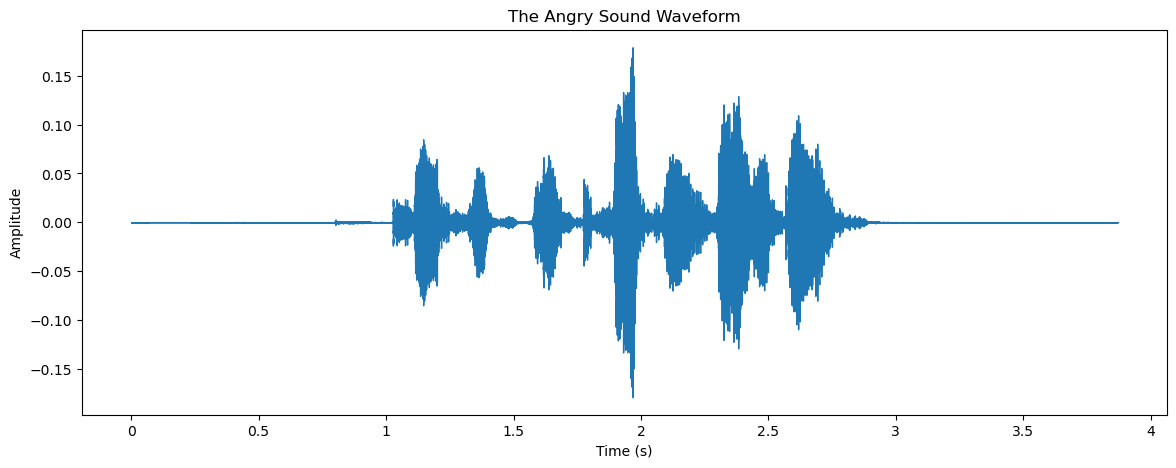

The Angry Sound: 


In [7]:
waveform(myPath+'/Angry/03-01-05-01-01-01-01.wav','Angry')


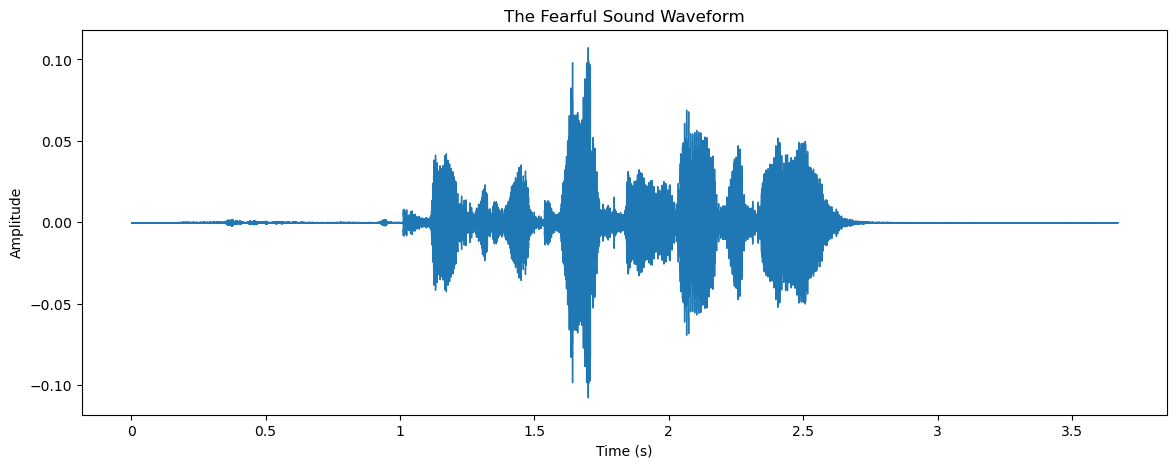

The Fearful Sound: 


In [29]:
waveform(myPath + '//Fearful/03-01-06-01-01-01-01.wav','Fearful')


In [6]:
def do_melspectrogram(sound_files):
    sample_rate = 44100  

    mel_spectrogram_dbs_list = []

    for i in tqdm(range(len(sound_files))):
        
        audio_segment = sound_files[i]

        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".wav")
        temp_file_path = temp_file.name
        temp_file.close()

        
        audio_segment.export(temp_file_path, format="wav")

    
        signal, sample_rate = librosa.load(temp_file_path, sr=sample_rate)

        os.remove(temp_file_path)

        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate) 

        mel_spectrogram_dbs = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

        mel_spectrogram_dbs_list.append(mel_spectrogram_dbs)

    return mel_spectrogram_dbs_list

In [7]:
def show_mel_spectrogram(mel_spectrogram):  
    df_mel_spectrogram = pd.DataFrame(mel_spectrogram)
    plt.figure(figsize=(10, 4))
    sns.heatmap(df_mel_spectrogram, cmap='plasma', xticklabels=10, yticklabels=10)
    plt.title(f'Mel Spectrogram  (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency Bin')
    plt.show()

In [174]:
mel_spectrogram_dbs_angry = do_melspectrogram(angry_sounds)
mel_spectrogram_dbs_disgusted = do_melspectrogram(disgusted_sounds)
mel_spectrogram_dbs_fearful = do_melspectrogram(fearful_sounds)
mel_spectrogram_dbs_happy = do_melspectrogram(happy_sounds)
mel_spectrogram_dbs_neutral = do_melspectrogram(neutral_sounds)
mel_spectrogram_dbs_surprised = do_melspectrogram(suprised_sounds)
mel_spectrogram_dbs_sad = do_melspectrogram(sad_sounds)


100%|██████████| 2167/2167 [00:14<00:00, 149.11it/s]


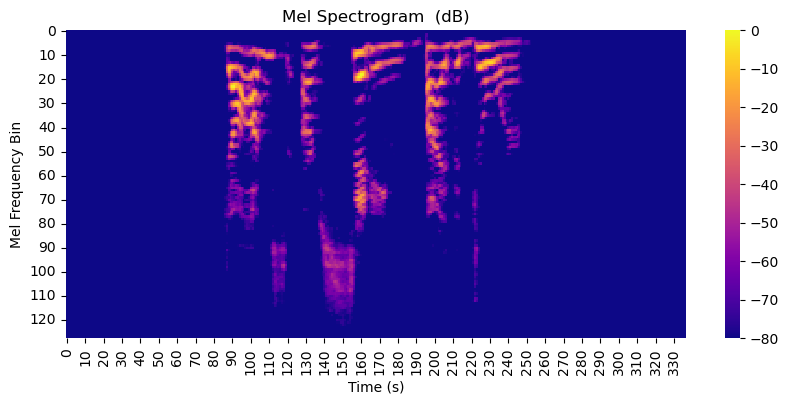

In [9]:
show_mel_spectrogram(mel_spectrogram_dbs_angry[0])


In [134]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Surface(z=mel_spectrogram_dbs_disgusted[19].T, colorscale='viridis')
])

fig.update_layout(
    title='Mel Spectrogram (dB)',
    scene=dict(
        xaxis=dict(title='Time (s)'),
        yaxis=dict(title='Mel Frequency Bin'),
        zaxis=dict(title='Amplitude (dB)')
    )
)

fig.show()

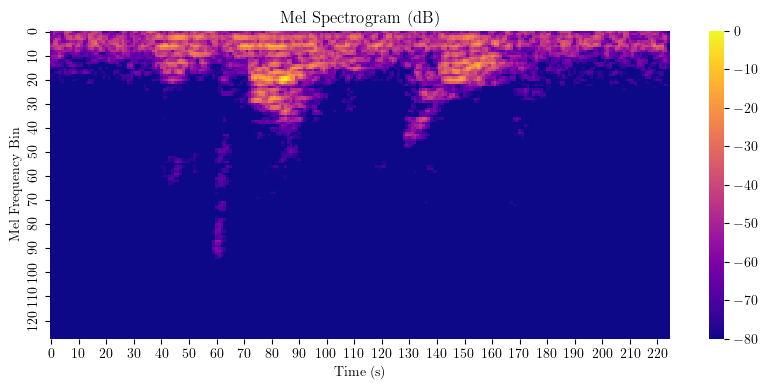

In [74]:
show_mel_spectrogram(mel_spectrogram_dbs_disgusted[4])


In [38]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Surface(z=mel_spectrogram_dbs_disgusted[0].T, colorscale='viridis')
])

fig.update_layout(
    title='Mel Spectrogram (dB)',
    scene=dict(
        xaxis=dict(title='Time (s)'),
        yaxis=dict(title='Mel Frequency Bin'),
        zaxis=dict(title='Amplitude (dB)')
    )
)

fig.show()

In [80]:
def spectrogram_to_3d_points_vec(spectrogram):
    freq_bins, time_frames = spectrogram.shape
    t, f = np.meshgrid(np.arange(time_frames), np.arange(freq_bins))
    a = spectrogram

    return np.stack([t.flatten(), f.flatten(), a.flatten()], axis=1)

In [82]:
spectrogram_to_3d_points_vec(mel_spectrogram_dbs_disgusted[0]).shape

(31744, 3)

In [224]:
computePersistanceDiagram(mel_spectrogram_dbs_angry[3], 1, 3, euclideanMetric, True)

In [60]:
distance_matrix = squareform(pdist(mel_spectrogram_dbs_angry[3].T, metric=euclideanMetric))

In [52]:
distance_matrix.max() / 50

17.090672302246094

In [10]:
from gudhi import RipsComplex
import gudhi as gd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from gudhi.representations import Landscape
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from gudhi.representations import PersistenceImage 
from pathos.multiprocessing import ProcessingPool as Pool


In [223]:


def euclideanMetric(x, y):
    # print(x)
    # print(y)
    x[0] = 0
    y[0] = 0
    return np.linalg.norm(x - y) 
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)  
    norm_A = np.linalg.norm(A)  
    norm_B = np.linalg.norm(B) 
    return dot_product / (norm_A * norm_B) 

def newMetric(x, y):
    norm_A = np.linalg.norm(x[1:])  
    norm_B = np.linalg.norm(y[1:]) 
    norm_C = np.linalg.norm(x[0])
    norm_D = np.linalg.norm(y[0])
    # print(2*np.linalg.norm(x[0] - y[0]) / (norm_C+norm_D))
    return 2*np.linalg.norm(x[0] - y[0]) / (norm_C+norm_D) + 2* np.linalg.norm(x[1:] - y[1:]) / (norm_A + norm_B)

def computePersistanceDiagram(matrix, maxlength, maxdim, metric, plot):
    row = np.arange(matrix.shape[1]) 
    new_arr = np.vstack([row, matrix])
    distance_matrix = squareform(pdist(new_arr.T, metric=metric))
    rips_complex = RipsComplex(points=new_arr.T, max_edge_length=maxlength, distance_matrix=distance_matrix)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=maxdim)
    simplex_tree.compute_persistence()
    persistence = simplex_tree.persistence()
    myBd = []
    for i in range(maxdim):
        birth_death_matrix = np.array([
            [birth, death] for dim, (birth, death) in persistence if dim == i and death != float('inf')
        ])
        myBd.append(birth_death_matrix)
    if plot:
        gd.plot_persistence_diagram(simplex_tree.persistence())
    return myBd

In [12]:
import logging
logging.basicConfig(
    filename='debug.log',
    level=logging.INFO,
    format='%(processName)s - %(message)s'
)

def computePersistanceFromDb(aDb, maxlength, maxdim, metric, plot, maxdiagrams):
    myMat = []
    for i, myCurr in enumerate(aDb):
        if i == maxdiagrams:
            break
        logging.info(f"Computing persitance diagram for {i}")
        persitance_mat = computePersistanceDiagram(myCurr, maxlength, maxdim, metric, plot)
        myMat.append(persitance_mat)
    return myMat

In [13]:


# Define the parallel_compute_persistence function at the top level
def parallel_compute_persistence(args):
    def computePersistanceDiagram(matrix, maxlength, maxdim, metric, plot):
        row = np.arange(matrix.shape[1]) 
        new_arr = np.vstack([row, matrix])
        distance_matrix = squareform(pdist(new_arr.T, metric=metric))
        rips_complex = RipsComplex(points=new_arr.T, max_edge_length=maxlength, distance_matrix=distance_matrix)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=maxdim)
        simplex_tree.compute_persistence()
        persistence = simplex_tree.persistence()
        myBd = []
        for i in range(maxdim):
            birth_death_matrix = np.array([
                [birth, death] for dim, (birth, death) in persistence if dim == i and death != float('inf')
            ])
            myBd.append(birth_death_matrix)
        if plot:
            gd.plot_persistence_diagram(simplex_tree.persistence())
        return myBd
    def computePersistanceFromDb(aDb, maxlength, maxdim, metric, plot, maxdiagrams):
        myMat = []
        for i, myCurr in enumerate(aDb):
            if i == maxdiagrams:
                break
            logging.info(f"Computing persitance diagram for {i}")
            persitance_mat = computePersistanceDiagram(myCurr, maxlength, maxdim, metric, plot)
            myMat.append(persitance_mat)
        return myMat
    return computePersistanceFromDb(*args)

# Define the arguments for each call to your function


In [176]:
myMaxDist = 0.5
maxDim = 2
args = [
    (mel_spectrogram_dbs_angry, myMaxDist, maxDim, newMetric, False, 400),
    (mel_spectrogram_dbs_disgusted, myMaxDist, maxDim, newMetric, False, 400),
    (mel_spectrogram_dbs_fearful, myMaxDist, maxDim, newMetric, False, 400),
    (mel_spectrogram_dbs_happy, myMaxDist, maxDim, newMetric, False, 400),
    (mel_spectrogram_dbs_neutral, myMaxDist, maxDim, newMetric, False, 400),
    (mel_spectrogram_dbs_surprised, myMaxDist, maxDim, newMetric, False, 400),
    (mel_spectrogram_dbs_sad, myMaxDist, maxDim, newMetric, False, 400)
]
# Create a pool and use map to run the function in parallel
with Pool() as pool:
    results = pool.map(parallel_compute_persistence, args)
myAngry, myDisgusted, myFearful, myHappy, myNeutral, mySurprised, mySad = results

# myMaxDist_w = 1
# args = [
#     (mel_spectrogram_dbs_angry, myMaxDist_w, 3, wasserstein_distance, False, 200),
#     (mel_spectrogram_dbs_disgusted, myMaxDist_w, 3, wasserstein_distance, False, 200),
#     (mel_spectrogram_dbs_fearful, myMaxDist_w, 3, wasserstein_distance, False, 200),
#     (mel_spectrogram_dbs_happy, myMaxDist_w, 3, wasserstein_distance, False, 200),
#     (mel_spectrogram_dbs_neutral, myMaxDist_w, 3, wasserstein_distance, False, 200),
#     (mel_spectrogram_dbs_surprised, myMaxDist_w, 3, wasserstein_distance, False, 200),
#     (mel_spectrogram_dbs_sad, myMaxDist_w, 3, wasserstein_distance, False, 200)
# ]
# with Pool() as pool:
#     results = pool.map(parallel_compute_persistence, args)
# myAngryW, myDisgustedW, myFearfulW, myHappyW, myNeutralW, mySurprisedW, mySadW = results

# Unpack the results
# myAngry, myDisgusted = results


In [148]:
def getPersitanceHeatMap(aArr, aMax, maxdim):
    heatmap_arr = []
    for value in aArr:
        persistence_image = PersistenceImage(
            bandwidth=aMax / 50,            # smoothing kernel bandwidth
            weight=lambda x: x[1] - x[0],  # weight = persistence
            resolution=[128, 128],      # heatmap resolution
            im_range=[0, aMax, 0, aMax]     # [birth_min, birth_max, death_min, death_max]
        )

        for i in range(maxdim):
            if len(value[i]) > 0:
                heatmap = persistence_image.fit_transform([value[i]])[0]
                heatmap_2d = heatmap.reshape(128, 128)
                heatmap_arr.append(heatmap_2d)
            else:
                heatmap_arr.append(np.zeros((128, 128)))
    # return heatmap_arr
    # Plot the heatmap
    plt.imshow(heatmap_2d, cmap='hot', origin='lower')
    plt.colorbar(label='Probability Density')
    plt.title('Persistence Image')
    plt.xlabel('Birth')
    plt.ylabel('Death')
    plt.show()
    return heatmap_arr

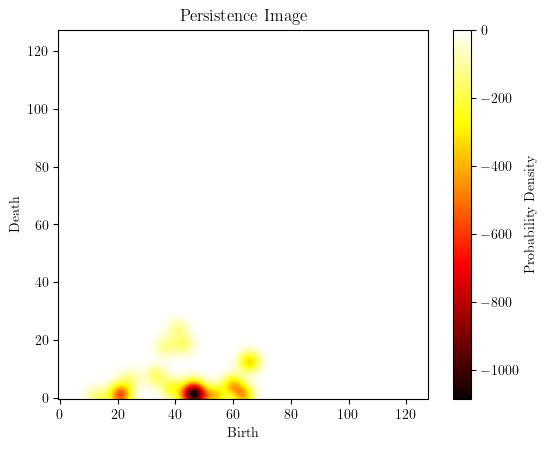

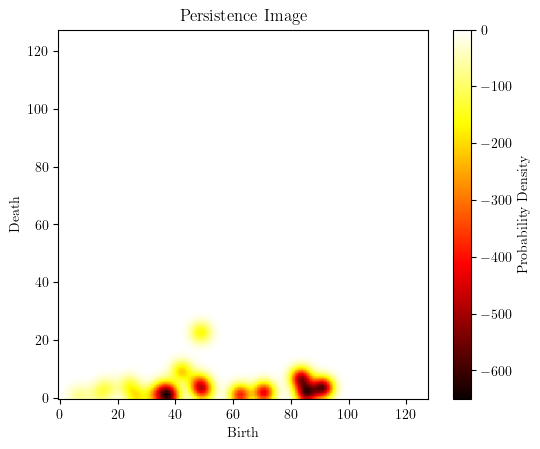

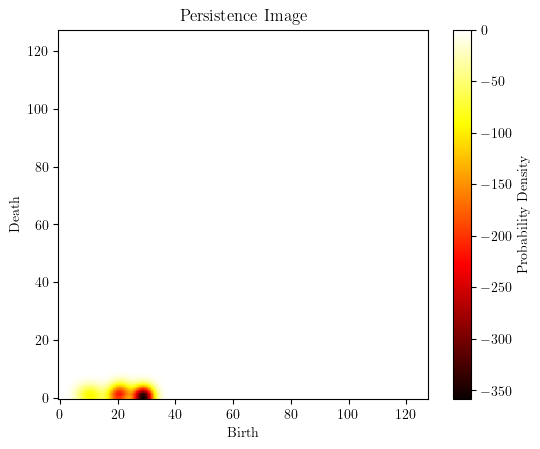

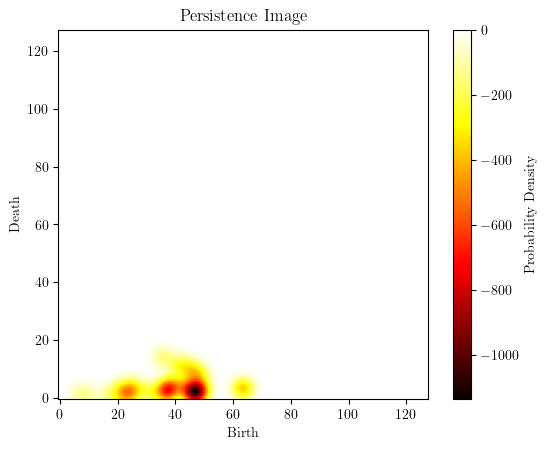

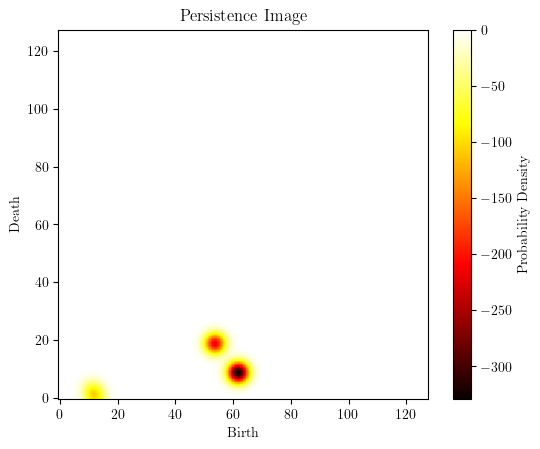

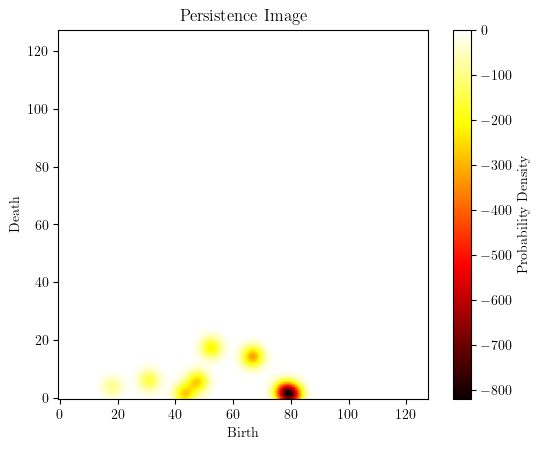

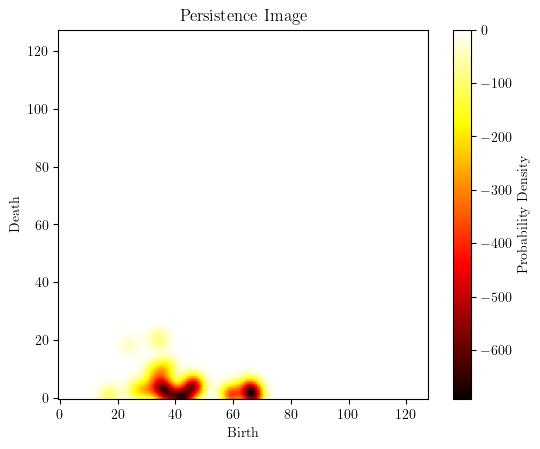

In [177]:

myAngryHeat = getPersitanceHeatMap(myAngry, aMax=myMaxDist, maxdim=maxDim)
myDisgustedHeat = getPersitanceHeatMap(myDisgusted, aMax=myMaxDist, maxdim=maxDim)
myFearfulHeat = getPersitanceHeatMap(myFearful, aMax=myMaxDist, maxdim=maxDim)
myHappyHeat = getPersitanceHeatMap(myHappy, aMax=myMaxDist, maxdim=maxDim)
myNeutralHeat = getPersitanceHeatMap(myNeutral, aMax=myMaxDist, maxdim=maxDim)
mySurprisedHeat = getPersitanceHeatMap(mySurprised, aMax=myMaxDist, maxdim=maxDim)
mySadHeat = getPersitanceHeatMap(mySad, aMax=myMaxDist, maxdim=maxDim)

# myAngryHeatW = getPersitanceHeatMap(myAngryW, aMax=myMaxDist_w, maxdim=2)
# myDisgustedHeatW = getPersitanceHeatMap(myDisgustedW, aMax=myMaxDist_w, maxdim=2)
# myFearfulHeatW = getPersitanceHeatMap(myFearfulW, aMax=myMaxDist_w, maxdim=2)
# myHappyHeatW = getPersitanceHeatMap(myHappyW, aMax=myMaxDist_w, maxdim=2)
# myNeutralHeatW = getPersitanceHeatMap(myNeutralW, aMax=myMaxDist_w, maxdim=2)
# mySurprisedHeatW = getPersitanceHeatMap(mySurprisedW, aMax=myMaxDist_w, maxdim=2)
# mySadHeatW = getPersitanceHeatMap(mySadW, aMax=myMaxDist_w, maxdim=2)


In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import kagglehub
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import math
from sklearn.datasets import load_iris
import tensorflow as tf 
from sklearn.model_selection import train_test_split
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Input, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from keras.datasets import mnist
from tensorflow.keras.metrics import AUC
from tensorflow.keras import regularizers



In [184]:
# myData = np.array([myAngryHeat[::3] + myDisgustedHeat[::3], myAngryHeat[1::3] + myDisgustedHeat[1::3], myAngryHeat[2::3] + myDisgustedHeat[2::3]], dtype=np.float32)
myData = np.array([myAngryHeat[::2] + myDisgustedHeat[::2] + myHappyHeat[::2] + mySurprisedHeat[::2] + mySadHeat[::2] + myNeutralHeat[::2] + myFearfulHeat[::2],
                myAngryHeat[1::2] + myDisgustedHeat[1::2] + myHappyHeat[1::2] + mySurprisedHeat[1::2] + mySadHeat[1::2] + myNeutralHeat[1::2] + myFearfulHeat[1::2]], dtype=np.float32)

myData = myData.astype('float32')
myData = np.transpose(myData, (1, 2, 3, 0))
myY = np.array([0 for x in range(400)] + [1 for x in range(400)] + [2 for x in range(400)] + [3 for x in range(400)] + [4 for x in range(400)] + [5 for x in range(400)] + [6 for x in range(400)])


In [185]:
X_train, X_test, y_train, y_test = train_test_split(
    myData, myY, test_size=0.2, shuffle=True
)

In [220]:
model = keras.Sequential([
    Input(shape=(128, 128, 2)),
    Conv2D(25, kernel_size=(5,5), activation='relu'),
    Conv2D(25, kernel_size=(3,3), activation='relu'),
    Flatten(),
    Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    Dense(7, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [222]:
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4182 - loss: 33.1156 - val_accuracy: 0.3804 - val_loss: 33.1496
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4052 - loss: 32.7250 - val_accuracy: 0.3554 - val_loss: 31.3382
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4177 - loss: 31.9171 - val_accuracy: 0.3714 - val_loss: 30.2431
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4220 - loss: 31.8851 - val_accuracy: 0.3804 - val_loss: 32.8413
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4023 - loss: 32.1761 - val_accuracy: 0.3929 - val_loss: 31.2331
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3951 - loss: 31.2007 - val_accuracy: 0.3786 - val_loss: 30.6699
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4098 - loss: 31.5517 - val_accuracy: 0.3964 - val_loss: 31.9766
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4170 - loss: 31.8524 - val_accuracy: 0.3571 - val_loss: 

In [141]:
# myAngryNew = computePersistanceFromDb(mel_spectrogram_dbs_angry[300:], 2, 3, wasserstein_distance, True, 2)
# myAngryHeatNew = getPersitanceHeatMap(myAngryNew, aMax=100, maxdim=2)


In [492]:
myDataNew = np.array([myAngryHeatNew[::2], myAngryHeatNew[1::2]], dtype=np.float32)
myDataNew = myDataNew.astype('float32')
myDataNew = np.transpose(myDataNew, (1, 2, 3, 0))
predicted_classes = np.argmax(model.predict(myDataNew), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [493]:
model.predict(myDataNew)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([[0.16383244],
       [0.16360456]], dtype=float32)

In [477]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])